In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

***Flickr30k Image Feature Extraction Using Pretrained ResNet50***

In [ ]:
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

def find_image_dir():
    # Common Kaggle root
    base_input = '/kaggle/input'
    # Walk through the input directory to find where the images actually are
    for root, dirs, files in os.walk(base_input):
        # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")

# --- THE DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

# --- REMAINDER OF THE PIPELINE (AS BEFORE) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])  # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]
Extracting Features: 100%|██████████| 249/249 [01:47<00:00,  2.31it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


***Flickr30k Dataset Loading and Train/Validation/Test Split Preparation***

In [ ]:
import os
import json
import random

print("Listing input directory to help debug:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"Found: {dirname}")
    if 'captions.txt' in filenames:
        print(f" → captions.txt is here: {os.path.join(dirname, 'captions.txt')}")
    if len(filenames) > 0 and any(f.endswith('.json') for f in filenames):
        print(f" → JSON files: {[f for f in filenames if f.endswith('.json')]}")

# ────────────────────────────────────────────────
# Try Karpathy splits first (if you successfully downloaded & extracted)
karpathy_json = '/kaggle/working/dataset_flickr30k.json'

if os.path.exists(karpathy_json):
    print("\nUsing Karpathy splits from downloaded JSON")
    with open(karpathy_json, 'r') as f:
        data = json.load(f)
    images = data['images']
    train_images = [img for img in images if img['split'] == 'train']
    val_images   = [img for img in images if img['split'] == 'val']
    test_images  = [img for img in images if img['split'] == 'test']

else:
    print("\nKarpathy JSON not found → falling back to captions.txt from dataset")

    # Correct path for adityajn105/flickr30k dataset (very common pattern)
    possible_caption_paths = [
        '/kaggle/input/datasets/adityajn105/flickr30k/captions.txt',
        '/kaggle/input/flickr30k/captions.txt',
        '/kaggle/input/adityajn105-flickr30k/captions.txt',  # sometimes slug changes
    ]

    captions_path = None
    for p in possible_caption_paths:
        if os.path.exists(p):
            captions_path = p
            break

    if captions_path is None:
        raise FileNotFoundError(
            "captions.txt not found. Checked:\n" +
            "\n".join(possible_caption_paths) +
            "\n\nPlease check your dataset addition → look at printed paths above."
        )

    print(f"Using captions.txt from: {captions_path}")

    # Load captions.txt (format: image_name.jpg, caption text)
    img_to_captions = {}
    with open(captions_path, 'r', encoding='utf-8') as f:
        next(f)  # skip header: image,caption
        for line in f:
            if not line.strip():
                continue
            try:
                img_id, caption = line.strip().split(',', 1)
                if img_id not in img_to_captions:
                    img_to_captions[img_id] = []
                img_to_captions[img_id].append({'raw': caption})
            except:
                continue  # skip malformed lines if any

    all_imgs = list(img_to_captions.keys())
    print(f"Total unique images found in captions.txt: {len(all_imgs)}")

    random.seed(42)
    random.shuffle(all_imgs)
    n = len(all_imgs)

    train_images = [{'filename': fn, 'sentences': img_to_captions[fn]} for fn in all_imgs[:int(0.8 * n)]]
    val_images   = [{'filename': fn, 'sentences': img_to_captions[fn]} for fn in all_imgs[int(0.8 * n):int(0.9 * n)]]
    test_images  = [{'filename': fn, 'sentences': img_to_captions[fn]} for fn in all_imgs[int(0.9 * n):]]

print(f"\nFinal splits → Train: {len(train_images):,} | Val: {len(val_images):,} | Test: {len(test_images):,}")

Listing input directory to help debug:
Found: /kaggle/input
Found: /kaggle/input/datasets
Found: /kaggle/input/datasets/adityajn105
Found: /kaggle/input/datasets/adityajn105/flickr30k
 → captions.txt is here: /kaggle/input/datasets/adityajn105/flickr30k/captions.txt
Found: /kaggle/input/datasets/adityajn105/flickr30k/Images
Found: /kaggle/input/datasets/adityajn105/flickr30k/Images/flickr30k_images

Karpathy JSON not found → falling back to captions.txt from dataset
Using captions.txt from: /kaggle/input/datasets/adityajn105/flickr30k/captions.txt
Total unique images found in captions.txt: 31783

Final splits → Train: 25,426 | Val: 3,178 | Test: 3,179


In [ ]:
import re
from collections import Counter


***Caption Preprocessing and Vocabulary Construction***

In [ ]:
def preprocess_caption(caption):
    caption = caption.lower().strip()
    caption = re.sub(r'[^a-z\s]', '', caption)
    words = caption.split()
    return ['<start>'] + words + ['<end>']

word_counts = Counter()
for img in train_images:
    for sent in img['sentences']:
        words = preprocess_caption(sent['raw'])[1:-1]  # exclude specials for counting
        word_counts.update(words)

min_freq = 5
vocab = ['<pad>', '<unk>', '<start>', '<end>'] + sorted([w for w, c in word_counts.items() if c >= min_freq])
word_to_id = {w: i for i, w in enumerate(vocab)}
id_to_word = {i: w for w, i in word_to_id.items()}
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size} (min freq = {min_freq})")

# Max length (from train)
max_len = max(len(preprocess_caption(s['raw'])) for img in train_images for s in img['sentences'])
max_len = min(max_len, 40) + 2  # cap + safety
print(f"Max caption length (capped): {max_len}")

Vocabulary size: 6965 (min freq = 5)
Max caption length (capped): 42


***Loading Pre-extracted Image Features***

In [ ]:
with open('/kaggle/working/flickr30k_features.pkl', 'rb') as f:
    features_dict = pickle.load(f)
print(f"Loaded {len(features_dict)} image features")

Loaded 31783 image features


***Dataset Class and DataLoader Setup for Image-Caption Pairs***

In [ ]:
class CaptionDataset(Dataset):
    def __init__(self, images_list, features_dict, word_to_id, max_len):
        self.data = []
        for img in images_list:
            fn = img['filename']
            if fn not in features_dict:
                continue
            feat = torch.from_numpy(features_dict[fn]).float()
            for sent in img['sentences']:
                cap = preprocess_caption(sent['raw'])
                cap_ids = [word_to_id.get(w, word_to_id['<unk>']) for w in cap]
                if len(cap_ids) > max_len:
                    cap_ids = cap_ids[:max_len]
                else:
                    cap_ids += [word_to_id['<pad>']] * (max_len - len(cap_ids))
                self.data.append((feat, torch.tensor(cap_ids, dtype=torch.long)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_ds = CaptionDataset(train_images, features_dict, word_to_id, max_len)
val_ds   = CaptionDataset(val_images,   features_dict, word_to_id, max_len)
test_ds  = CaptionDataset(test_images,  features_dict, word_to_id, max_len)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

***Encoder-Decoder Model Definition for Image Captioning***

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc = nn.Linear(2048, hidden_size)

    def forward(self, x):
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=word_to_id['<pad>'])
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size

    def forward(self, features, captions):
        embeds = self.embed(captions[:, :-1])
        embeds = self.dropout(embeds)
        h0 = features.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)
        lstm_out, _ = self.lstm(embeds, (h0, c0))
        logits = self.fc(lstm_out)
        return logits

hidden_size = 512
embed_size  = 512
num_layers  = 1
dropout     = 0.5

encoder = Encoder(hidden_size).to(device)
decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers, dropout).to(device)

***Training Loop for Encoder-Decoder Image Captioning Model with Early Stopping***

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm

# Optimizer & Scheduler
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_id['<pad>'])

# Training settings
epochs = 8                  # Max epochs
patience_es = 5              # Early stopping patience
train_losses, val_losses = [], []

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    encoder.train()
    decoder.train()
    train_loss = 0.0
    for feats, caps in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        feats, caps = feats.to(device), caps.to(device)
        enc_out = encoder(feats)
        logits = decoder(enc_out, caps)
        loss = criterion(logits.reshape(-1, vocab_size), caps[:, 1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), 5.0)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    encoder.eval()
    decoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for feats, caps in val_loader:
            feats, caps = feats.to(device), caps.to(device)
            enc_out = encoder(feats)
            logits = decoder(enc_out, caps)
            loss = criterion(logits.reshape(-1, vocab_size), caps[:, 1:].reshape(-1))
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early Stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save best model
        torch.save(encoder.state_dict(), 'encoder_best.pth')
        torch.save(decoder.state_dict(), 'decoder_best.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience_es:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

# Save final model
torch.save(encoder.state_dict(), 'encoder_final.pth')
torch.save(decoder.state_dict(), 'decoder_final.pth')


Epoch 1: 100%|██████████| 1987/1987 [01:11<00:00, 27.96it/s]


Epoch  1 | Train Loss: 3.8996 | Val Loss: 3.3769 | LR: 0.000500


Epoch 2: 100%|██████████| 1987/1987 [01:10<00:00, 28.27it/s]


Epoch  2 | Train Loss: 3.2459 | Val Loss: 3.1375 | LR: 0.000500


Epoch 3: 100%|██████████| 1987/1987 [01:10<00:00, 28.28it/s]


Epoch  3 | Train Loss: 3.0247 | Val Loss: 3.0370 | LR: 0.000500


Epoch 4: 100%|██████████| 1987/1987 [01:10<00:00, 28.08it/s]


Epoch  4 | Train Loss: 2.8885 | Val Loss: 2.9852 | LR: 0.000500


Epoch 5: 100%|██████████| 1987/1987 [01:10<00:00, 28.15it/s]


Epoch  5 | Train Loss: 2.7899 | Val Loss: 2.9537 | LR: 0.000500


Epoch 6: 100%|██████████| 1987/1987 [01:10<00:00, 28.24it/s]


Epoch  6 | Train Loss: 2.7105 | Val Loss: 2.9336 | LR: 0.000500


Epoch 7: 100%|██████████| 1987/1987 [01:10<00:00, 28.27it/s]


Epoch  7 | Train Loss: 2.6435 | Val Loss: 2.9290 | LR: 0.000500


Epoch 8: 100%|██████████| 1987/1987 [01:10<00:00, 28.33it/s]


Epoch  8 | Train Loss: 2.5851 | Val Loss: 2.9223 | LR: 0.000500


***Greedy and Beam Search Decoding for Caption Generation***

In [ ]:
@torch.no_grad()
def greedy_decode(encoder, decoder, feature, max_len=40):
    encoder.eval(); decoder.eval()
    feature = feature.unsqueeze(0).to(device)
    enc_out = encoder(feature)
    hidden = enc_out.unsqueeze(0).repeat(decoder.num_layers, 1, 1)
    cell = torch.zeros_like(hidden)
    input_token = torch.tensor([[word_to_id['<start>']]], device=device)
    caption = []
    for _ in range(max_len):
        embed = decoder.embed(input_token)
        output, (hidden, cell) = decoder.lstm(embed, (hidden, cell))
        logit = decoder.fc(output.squeeze(1))
        pred = logit.argmax(-1).item()
        if pred == word_to_id['<end>']:
            break
        caption.append(id_to_word[pred])
        input_token = torch.tensor([[pred]], device=device)
    return ' '.join(caption)

@torch.no_grad()
def beam_decode(encoder, decoder, feature, beam_size=3, max_len=40):
    encoder.eval(); decoder.eval()
    feature = feature.unsqueeze(0).to(device)
    enc_out = encoder(feature)
    hidden = enc_out.unsqueeze(0).repeat(decoder.num_layers, 1, 1)
    cell = torch.zeros_like(hidden)

    # (score, caption_ids, hidden, cell)
    candidates = [ (0.0, [word_to_id['<start>']], hidden, cell) ]
    finished = []

    for step in range(max_len):
        new_cands = []
        for score, seq, h, c in candidates:
            if seq[-1] == word_to_id['<end>']:
                finished.append((score / (len(seq)-1 + 1e-9), seq))
                continue
            inp = torch.tensor([[seq[-1]]], device=device)
            emb = decoder.embed(inp)
            out, (nh, nc) = decoder.lstm(emb, (h, c))
            logit = decoder.fc(out.squeeze(1))
            logp = torch.log_softmax(logit, dim=-1)
            top_logp, top_idx = logp.topk(beam_size)
            for i in range(beam_size):
                new_score = score + top_logp[0,i].item()
                new_seq = seq + [top_idx[0,i].item()]
                new_cands.append((new_score, new_seq, nh, nc))

        candidates = sorted(new_cands, key=lambda x: x[0] / (len(x[1])-1 + 1e-9), reverse=True)[:beam_size]
        if not candidates:
            break

    if finished:
        best = max(finished, key=lambda x: x[0])[1][1:]  # remove <start>
    else:
        best = max(candidates, key=lambda x: x[0] / (len(x[1])-1 + 1e-9))[1][1:]

    return ' '.join(id_to_word.get(i, '<unk>') for i in best if i != word_to_id['<end>'])

In [ ]:
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')


In [ ]:
# For plotting
import matplotlib.pyplot as plt
from PIL import Image
import os
import random


***Visualizing Generated Captions on Test Images***

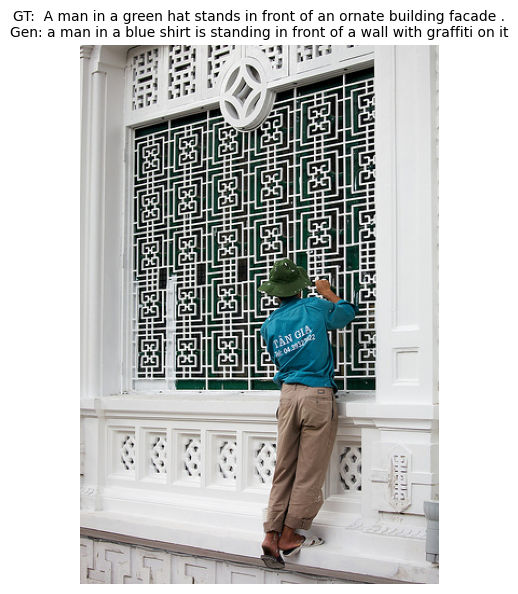

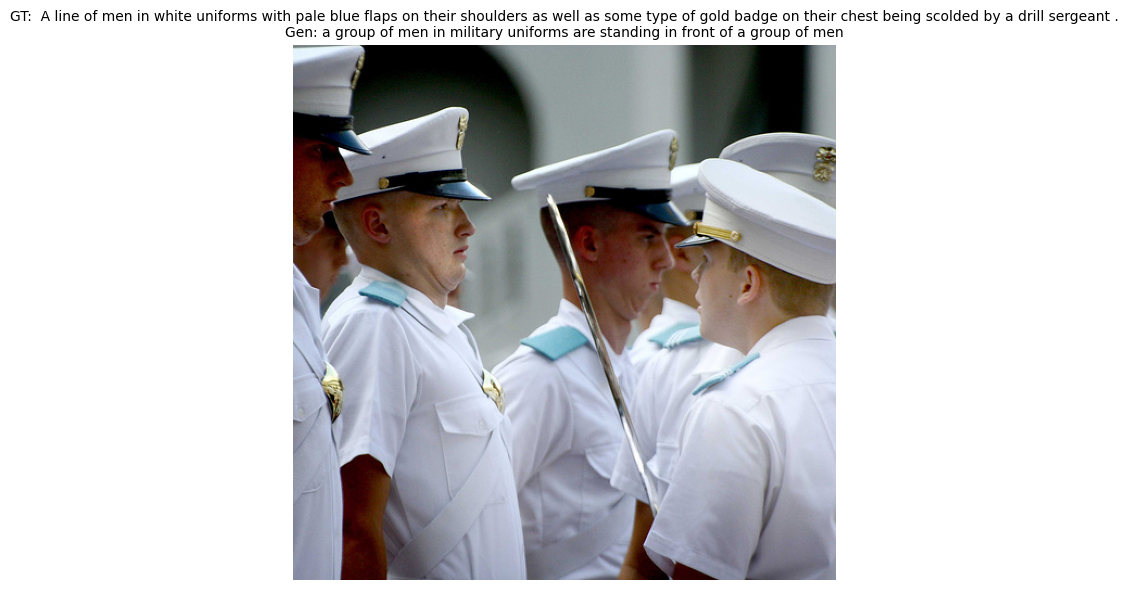

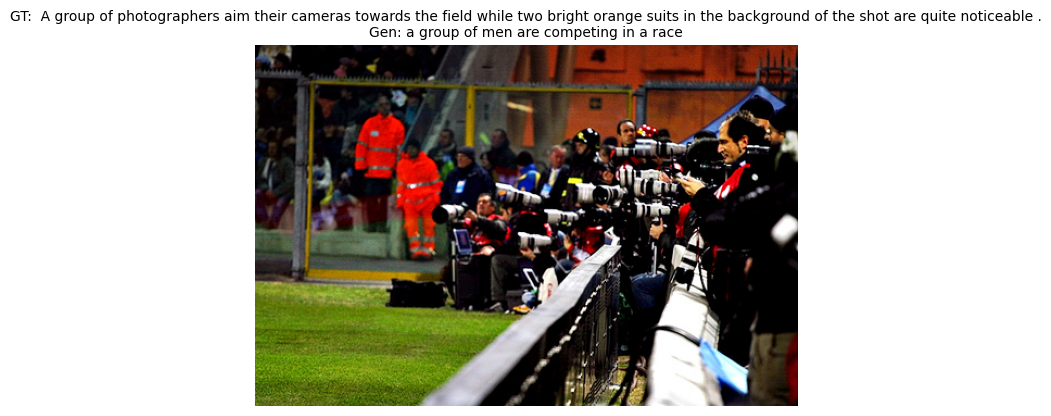

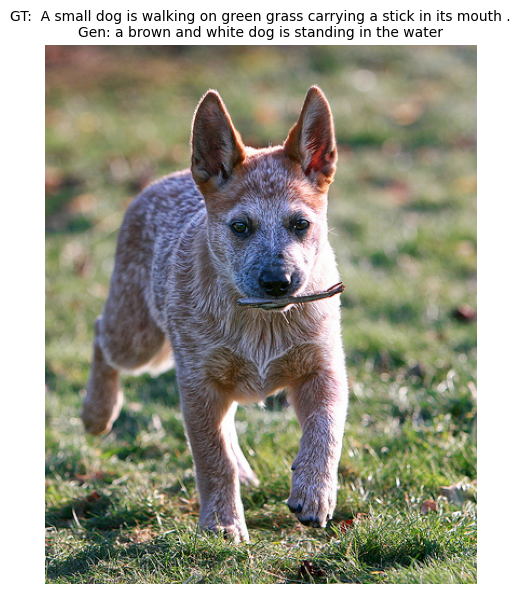

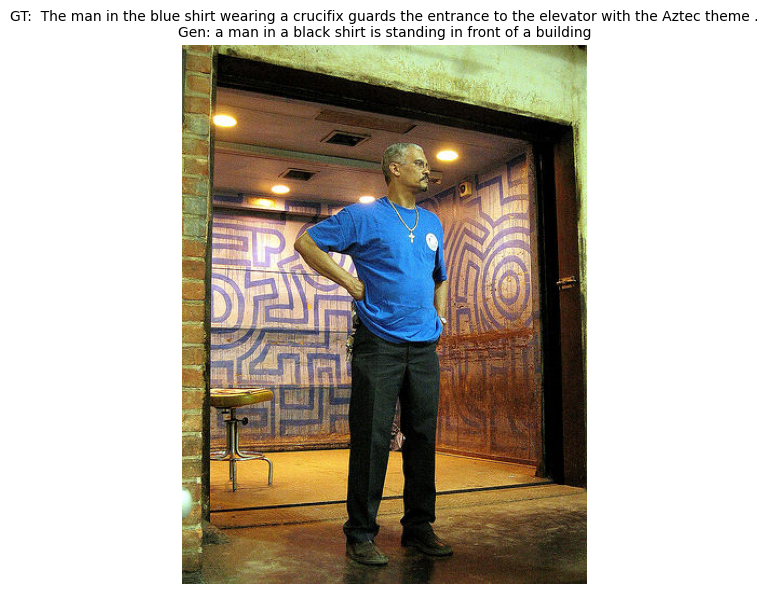

In [ ]:
encoder.load_state_dict(torch.load('encoder.pth'))
decoder.load_state_dict(torch.load('decoder.pth'))

random_test = random.sample(test_images, 5)

for img in random_test:
    fn = img['filename']
    if fn not in features_dict: continue
    feat = torch.from_numpy(features_dict[fn]).float()
    gen = beam_decode(encoder, decoder, feat, beam_size=3, max_len=max_len)
    gt = img['sentences'][0]['raw']

    plt.figure(figsize=(7,7))
    img_path = os.path.join(IMAGE_DIR, fn)  # IMAGE_DIR from feature extraction cell
    plt.imshow(Image.open(img_path))
    plt.title(f"GT: {gt}\nGen: {gen}", fontsize=10)
    plt.axis('off')
    plt.show()

***Plotting Training and Validation Loss Curves***

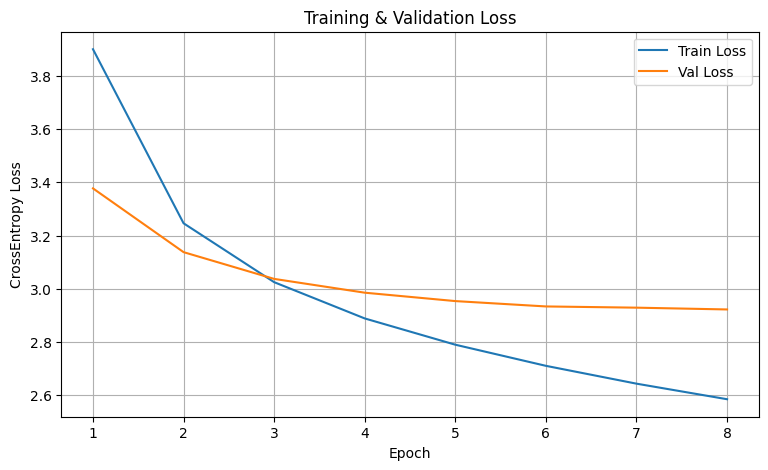

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

***Evaluating Generated Captions with BLEU-4 and METEOR Scores***

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm
import numpy as np
import torch

smooth = SmoothingFunction().method1
bleu4_list, meteor_list = [], []

for img in tqdm(test_images, desc="Evaluating test set"):
    fn = img['filename']
    if fn not in features_dict:
        continue
    feat = torch.from_numpy(features_dict[fn]).float()
    gen_caption = beam_decode(encoder, decoder, feat, beam_size=3, max_len=max_len)
    hyp = gen_caption.split()  # tokenized hypothesis

    refs = [s['raw'].lower().split() for s in img['sentences']]  # tokenized references
    bleu4 = sentence_bleu(refs, hyp, weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth)
    meteor = meteor_score(refs, hyp)  # tokenized version

    bleu4_list.append(bleu4)
    meteor_list.append(meteor)

print(f"Avg BLEU-4 : {np.mean(bleu4_list):.4f}")
print(f"Avg METEOR : {np.mean(meteor_list):.4f}")


Evaluating test set: 100%|██████████| 3179/3179 [02:19<00:00, 22.72it/s]

Avg BLEU-4 : 0.1619
Avg METEOR : 0.3469


Checking folder contents:
Found 1 items in /kaggle/input/asasasas
First few files: ['456789.png']

Found 1 valid images to test.
Model loaded successfully.
Loading ResNet50 feature extractor...
ResNet ready.


Generating captions:   0%|          | 0/1 [00:00<?, ?it/s]

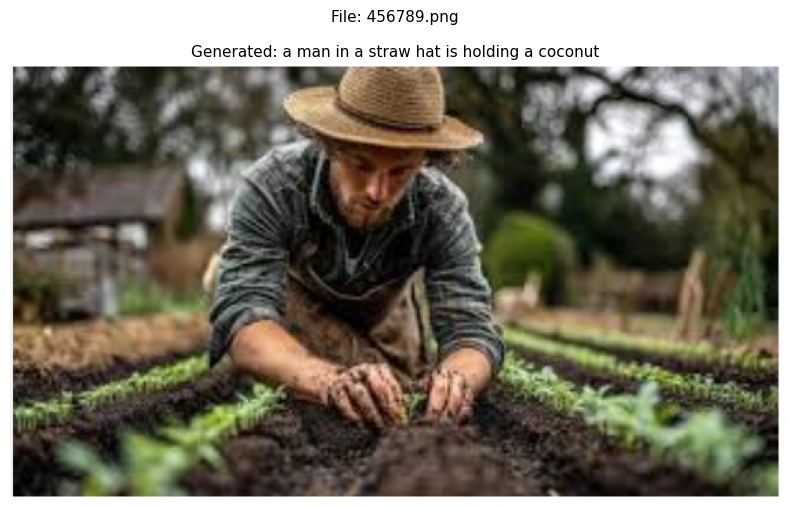

Generating captions: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

[1/1] 456789.png
→ a man in a straw hat is holding a coconut


All photos processed!


In [ ]:
# ================================================
#     TEST YOUR OWN PHOTOS FROM /kaggle/input/my-pics
# ================================================

import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm

# ─── Your photos path (exactly as you said) ────────
MY_PHOTOS_DIR = "/kaggle/input/asasasas"

# If your photos are inside a subfolder after upload, uncomment and adjust:
# MY_PHOTOS_DIR = "/kaggle/input/my-pics/images/"
# MY_PHOTOS_DIR = "/kaggle/input/my-pics/photos/"

# ─── Quick check: show what is actually there ──────
print("Checking folder contents:")
if os.path.exists(MY_PHOTOS_DIR):
    files = os.listdir(MY_PHOTOS_DIR)
    print(f"Found {len(files)} items in {MY_PHOTOS_DIR}")
    print("First few files:", files[:10])
else:
    print(f"Folder NOT FOUND: {MY_PHOTOS_DIR}")
    print("Available datasets:")
    print(os.listdir('/kaggle/input'))

# ─── Collect only image files ──────────────────────
image_paths = []
for root, dirs, files in os.walk(MY_PHOTOS_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            full_path = os.path.join(root, file)
            image_paths.append(full_path)

image_paths = sorted(image_paths)  # optional: sort by name
print(f"\nFound {len(image_paths)} valid images to test.")

if len(image_paths) == 0:
    print("No images found → please check:")
    print("1. Dataset name is exactly 'my-pics'")
    print("2. Photos are directly in the dataset (not in extra zip/folder)")
    print("3. File extensions are .jpg / .jpeg / .png")
    print("Try running !ls -R /kaggle/input/my-pics to see structure")
else:
    # ─── Load your model checkpoint (epoch 6 or best) ──
    # Change filenames if different
    encoder.load_state_dict(torch.load('encoder.pth'))          # or 'encoder_epoch_6.pth'
    decoder.load_state_dict(torch.load('decoder.pth'))          # or 'decoder_epoch_6.pth'
    encoder.eval()
    decoder.eval()
    print("Model loaded successfully.")

    # ─── Prepare ResNet feature extractor (same as training) ──
    if 'resnet_extractor' not in globals():
        print("Loading ResNet50 feature extractor...")
        resnet_extractor = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        resnet_extractor = nn.Sequential(*list(resnet_extractor.children())[:-1])
        resnet_extractor = nn.DataParallel(resnet_extractor).to(device)
        resnet_extractor.eval()
        print("ResNet ready.")

    # ─── Same image transform as in feature extraction ──
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    # ─── Generate captions and show results ────────────
    for idx, img_path in enumerate(tqdm(image_paths, desc="Generating captions")):
        try:
            # Load image
            img_pil = Image.open(img_path).convert('RGB')

            # Preprocess
            img_tensor = test_transform(img_pil).unsqueeze(0).to(device)

            # Extract 2048-dim feature
            with torch.no_grad():
                feature = resnet_extractor(img_tensor).squeeze()   # shape: (2048,)

            # Generate caption (use beam or greedy)
            # You can switch to greedy_decode if beam is too slow
            generated_caption = beam_decode(
                encoder,
                decoder,
                feature,
                beam_size=3,
                max_len=max_len
            )
            # generated_caption = greedy_decode(encoder, decoder, feature, max_len=max_len)

            # Display
            plt.figure(figsize=(8, 6))
            plt.imshow(img_pil)
            plt.title(f"File: {os.path.basename(img_path)}\n\nGenerated: {generated_caption}",
                      fontsize=11, wrap=True)
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            # Optional: print text only too
            print(f"[{idx+1}/{len(image_paths)}] {os.path.basename(img_path)}")
            print(f"→ {generated_caption}\n")

        except Exception as e:
            print(f"Error on {os.path.basename(img_path)} : {str(e)}")
            continue

    print("\nAll photos processed!")

Checking folder contents:
Found 1 items in /kaggle/input/zxzxzxzxzxz
First few files: ['dddddd.png']

Found 1 valid images to test.
Model loaded successfully.


Generating captions:   0%|          | 0/1 [00:00<?, ?it/s]

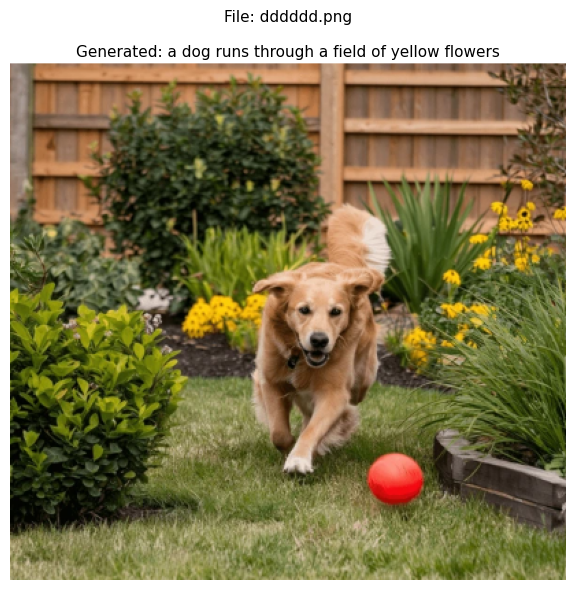

Generating captions: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

[1/1] dddddd.png
→ a dog runs through a field of yellow flowers


All photos processed!


In [ ]:
# ================================================
#     TEST YOUR OWN PHOTOS FROM /kaggle/input/my-pics
# ================================================

import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm

# ─── Your photos path (exactly as you said) ────────
MY_PHOTOS_DIR = "/kaggle/input/zxzxzxzxzxz"

# If your photos are inside a subfolder after upload, uncomment and adjust:
# MY_PHOTOS_DIR = "/kaggle/input/my-pics/images/"
# MY_PHOTOS_DIR = "/kaggle/input/my-pics/photos/"

# ─── Quick check: show what is actually there ──────
print("Checking folder contents:")
if os.path.exists(MY_PHOTOS_DIR):
    files = os.listdir(MY_PHOTOS_DIR)
    print(f"Found {len(files)} items in {MY_PHOTOS_DIR}")
    print("First few files:", files[:10])
else:
    print(f"Folder NOT FOUND: {MY_PHOTOS_DIR}")
    print("Available datasets:")
    print(os.listdir('/kaggle/input'))

# ─── Collect only image files ──────────────────────
image_paths = []
for root, dirs, files in os.walk(MY_PHOTOS_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            full_path = os.path.join(root, file)
            image_paths.append(full_path)

image_paths = sorted(image_paths)  # optional: sort by name
print(f"\nFound {len(image_paths)} valid images to test.")

if len(image_paths) == 0:
    print("No images found → please check:")
    print("1. Dataset name is exactly 'my-pics'")
    print("2. Photos are directly in the dataset (not in extra zip/folder)")
    print("3. File extensions are .jpg / .jpeg / .png")
    print("Try running !ls -R /kaggle/input/my-pics to see structure")
else:
    # ─── Load your model checkpoint (epoch 6 or best) ──
    # Change filenames if different
    encoder.load_state_dict(torch.load('encoder.pth'))          # or 'encoder_epoch_6.pth'
    decoder.load_state_dict(torch.load('decoder.pth'))          # or 'decoder_epoch_6.pth'
    encoder.eval()
    decoder.eval()
    print("Model loaded successfully.")

    # ─── Prepare ResNet feature extractor (same as training) ──
    if 'resnet_extractor' not in globals():
        print("Loading ResNet50 feature extractor...")
        resnet_extractor = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        resnet_extractor = nn.Sequential(*list(resnet_extractor.children())[:-1])
        resnet_extractor = nn.DataParallel(resnet_extractor).to(device)
        resnet_extractor.eval()
        print("ResNet ready.")

    # ─── Same image transform as in feature extraction ──
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    # ─── Generate captions and show results ────────────
    for idx, img_path in enumerate(tqdm(image_paths, desc="Generating captions")):
        try:
            # Load image
            img_pil = Image.open(img_path).convert('RGB')

            # Preprocess
            img_tensor = test_transform(img_pil).unsqueeze(0).to(device)

            # Extract 2048-dim feature
            with torch.no_grad():
                feature = resnet_extractor(img_tensor).squeeze()   # shape: (2048,)

            # Generate caption (use beam or greedy)
            # You can switch to greedy_decode if beam is too slow
            generated_caption = beam_decode(
                encoder,
                decoder,
                feature,
                beam_size=3,
                max_len=max_len
            )
            # generated_caption = greedy_decode(encoder, decoder, feature, max_len=max_len)

            # Display
            plt.figure(figsize=(8, 6))
            plt.imshow(img_pil)
            plt.title(f"File: {os.path.basename(img_path)}\n\nGenerated: {generated_caption}",
                      fontsize=11, wrap=True)
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            # Optional: print text only too
            print(f"[{idx+1}/{len(image_paths)}] {os.path.basename(img_path)}")
            print(f"→ {generated_caption}\n")

        except Exception as e:
            print(f"Error on {os.path.basename(img_path)} : {str(e)}")
            continue

    print("\nAll photos processed!")